In [1]:
from music21 import *
from tqdm import tqdm

import numpy as np
import sys, os

In [2]:
s = converter.parse('../data/dataset/[Traditional]/What_Shall_We_Do_with_a_Drunken_Sailor?/What_Shall_We_Do_with_a_Drunken_Sailor?.mxl')

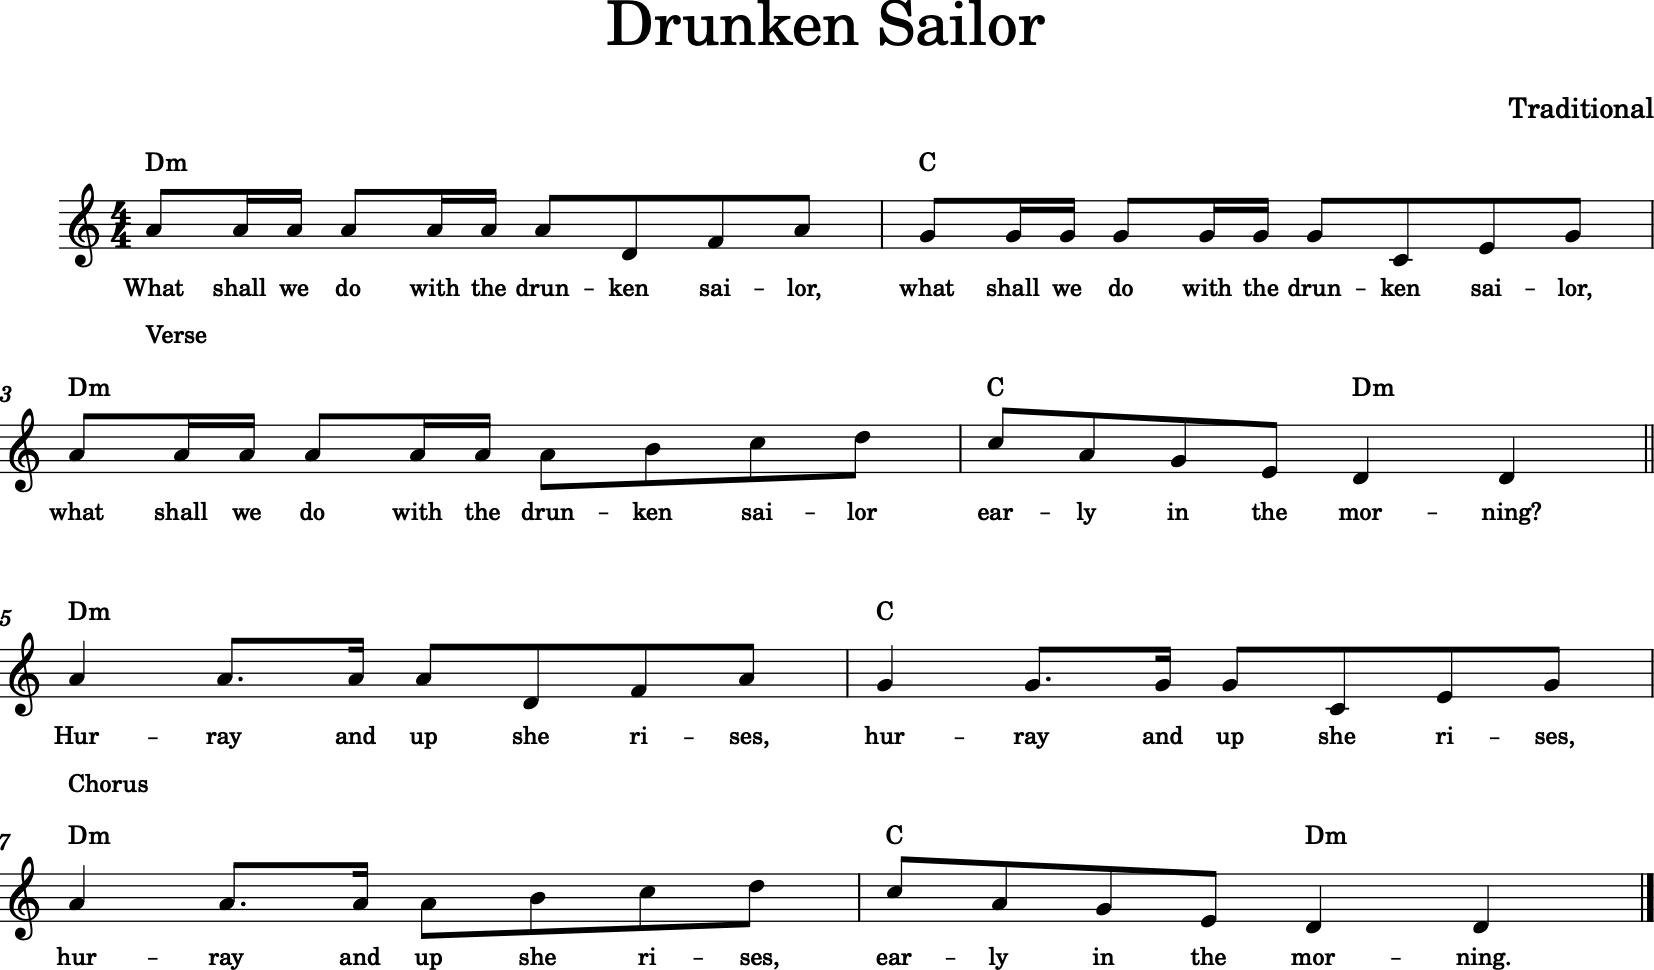

In [3]:
s.show()

# 모든 하위파일 검색

In [4]:
scores = []
for (path, dir, files) in os.walk("../"):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.mxl':
          scores.append(f"{path}/{filename}")

In [5]:
len(scores)

502

In [6]:
QUANTIZATION = 16 # 마디를 몇 비트로 분할할 것인가
PITCH = 128 # 음의 개수 (0~127)

In [7]:
def measure_timesignature_check(target:stream.Measure, name:str)->bool:
  if target.barDuration.quarterLength == 4: # 4비트 곡인 경우만 진행
    return True
  else:
    # print(f"{name}의 박자가 {target.barDuration.quarterLength} 입니다.")
    return False

In [8]:
def score_normality_check(target:stream.Score)-> 'tuple(bool, int)':
  if score_len % 4 == 0: # 마디의 수가 4의 배수인 경우만 진행
    return True, score_len
  else: # 마디의 수가 4의 배수가 아닌 경우 버리고 진행
    return False, score_len

In [13]:
def score_to_numpy(path:str)->'tuple(np.ndarray, np.ndarray, np.ndarray)':
  s = converter.parse(path)

  try:
    expanded_s = repeat.Expander(s.getElementsByClass(stream.Part)[0]).process()
    score_len = len(expanded_s) # stream의 전체 마디 수를 측정
  except (repeat.ExpanderException, stream.StreamException): # ExpanderException 상황 (반복 표시가 정상적이지 않아서 오류가 발생하는 경우도 음악을 버림)
    return None, None, None

  if score_len % 4 != 0: # 마디의 수가 4의 배수인 경우만 진행
    return None, None, None
  
  assert score_len % 4 == 0, "'{path}'의 마디 수가 정확하게 나눠지지 않았습니다."
  
  np_score = np.zeros(shape=(score_len * QUANTIZATION, PITCH)) # shape: 음악 길이 x 전체 음 수
  note_status = np.zeros(shape=(score_len * QUANTIZATION, 3)) # shape: 음악 길이 x 3(쉼표, 음 연주, 유지)
  chord_status = np.zeros(shape=(score_len * QUANTIZATION, 12)) # shape:  음악 길이 x 12(C~B)

  now_chord = [] # 현재 어떤 코드가 연주되고 있는지를 표시. 다음 코드가 나올 때 변경됨
  tie_status = False # 현재 이음줄이 유지되고 있는지를 표시. 다음 음이 나올 때 해제
  key_interval:interval.Interval = interval.Interval(0) # 현재 키와 목표 키(C/Am)간의 인터벌 표시
  
  for mIdx, m in enumerate(expanded_s.getElementsByClass(stream.Measure)): # Stream의 각 마디별로 반복
    if not measure_timesignature_check(m, path): # 4/4박 곡만 진행합니다.
      return None, None, None
    for k in m.getElementsByClass(key.Key): # 키 표시 체크. 키가 없으면 실행되지 않습니다.
      stream_mode:str = k.mode # ['major', 'minor']
      assert stream_mode in ['major', 'minor'], '[major, minor] 이외에 다른 조가 들어왔습니다.'

      if stream_mode == 'major':
        key_interval:interval.Interval = interval.Interval(k.tonic, pitch.Pitch('C')) # 다장조로 기본 피치 확인
      elif stream_mode == 'minor':
        key_interval:interval.Interval = interval.Interval(k.tonic, pitch.Pitch('A')) # 가단조로 기본 피치 확인

    assert key_interval is not None, f"'{path}'의 key 정보가 없습니다."
    # 루프 돌면서 변환 입력 시작 ---------------------------------------------------------
    for element in m.getElementsByClass([harmony.ChordSymbol, note.Note, note.Rest, tie.Tie]): # 코드와 노트, 쉼표만 찾아서 반복
      if type(element) == note.Note: # 노트를 발견한 경우...
        element.transpose(key_interval, inPlace=True) # C 또는 Am으로 피치 변환
        
        # np_score에 음 삽입
        # 현재위치 : mIdx * 16 (지금까지의 마디) + element.offset * 4 (타임스텝)
        pos = int(mIdx * 16 + element.offset * 4)
        note_len = int(element.duration.quarterLength * 4)
        # duration 만큼 반복해서 삽입합니다.
        np_score[pos:pos+note_len, element.pitch.midi] = 1

        # chord_status에 반복해서 삽입
        chord_status[pos:pos+note_len, now_chord] = 1

        # note_status에 반복해서 삽입
        if tie_status: # 이음줄이 있는 경우 모든 음이 holding 으로 볼 수 있음
          note_status[pos:pos+note_len, 2] = 1 # holding 부분 1로
          tie_status = False
        else:
          note_status[pos, 1] = 1 # onset 부분 1로
          note_status[pos+1:pos+note_len, 2] = 1 # holding 부분 1로

      elif type(element) == note.Rest: # 쉼표인 경우 체크
        pos = int(mIdx * 16 + element.offset * 4)
        note_len = int(element.duration.quarterLength * 4)
        
        # note_status에 쉼표 정보 추가
        note_status[pos:pos+note_len, 0] = 1 # rest 부분 1로

      elif type(element) == harmony.ChordSymbol: # 코드심볼 체크
        try:
          now_chord = [p.pitchClass for p in element.pitches]
          # now_chord = [element.root().pitchClass, element.third.pitchClass, element.fifth.pitchClass] # triad chord 음으로 저장
        except AttributeError: # 3음 또는 5음이 없는 경우 (대부분 sus4, sus2 코드이므로 도미넌트 트라이어드 코드로 치환합니다)
          element = harmony.ChordSymbol(root=element.root().step, kind='major')
          now_chord = [element.root().pitchClass, element.third.pitchClass, element.fifth.pitchClass] # triad chord 음으로 저장

      elif type(element) == tie.Tie: # 이음줄 상태이면 현재 음 다시 유지
        tie_status = True

  return np_score, chord_status, note_status

In [14]:
def eight_measure_cut(target, window:int = 4):
  """
  마디 데이터를 8마디씩 잘라서 추가합니다.
  """
  cut_measure = []
  for mIdx in range(0, len(target) - (QUANTIZATION * 8)+1, window * QUANTIZATION): # 마디 수 * 16 만큼의 길이를 가짐. 따라서 16 * 길이 수 만큼 빼고 반복하면 됨
      cut_measure.append(target[mIdx:mIdx+(8*QUANTIZATION), :])

  return np.stack(cut_measure, axis=0)

In [15]:
all_np_scores = []
all_chord_status = []
all_note_status = []

for score_path in tqdm(scores):
  np_score, chord_status, note_status = score_to_numpy(score_path)
  if np_score is not None and chord_status is not None and note_status is not None:
    all_np_scores.append(eight_measure_cut(np_score))
    all_chord_status.append(eight_measure_cut(chord_status))
    all_note_status.append(eight_measure_cut(note_status))

100%|██████████| 502/502 [01:21<00:00,  6.13it/s]


# TODO
- 곡이 너무 많이 손실됨 (현재 261곡 손실) - 박자표, 도돌이표 오류

# EDA

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
len(all_np_scores) == len(all_chord_status) == len(all_note_status)

True

In [18]:
concat_np_scores = np.concatenate(all_np_scores, axis=0)
concat_np_scores.shape

(1247, 128, 128)

In [19]:
concat_chord_status = np.concatenate(all_chord_status, axis=0)
concat_chord_status.shape

(1247, 128, 12)

In [20]:
concat_note_status = np.concatenate(all_note_status, axis=0)
concat_note_status.shape

(1247, 128, 3)

In [21]:
pd.DataFrame(np.sum(concat_chord_status, axis=0), index=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', "B"]).plot.bar(figsize=(20,10))

ValueError: Shape of passed values is (128, 12), indices imply (12, 12)

<AxesSubplot:>

<Figure size 1440x720 with 0 Axes>

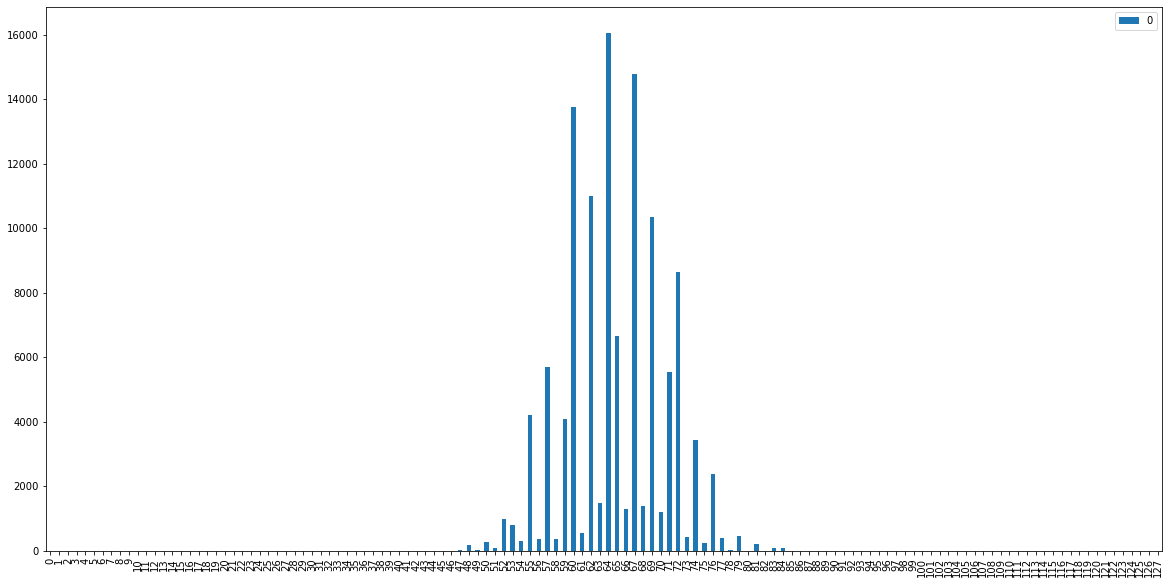

In [59]:
plt.figure(figsize=(20,10))
pd.DataFrame(np.sum(concat_np_scores, axis=0)).plot.bar(figsize=(20,10))

<AxesSubplot:>

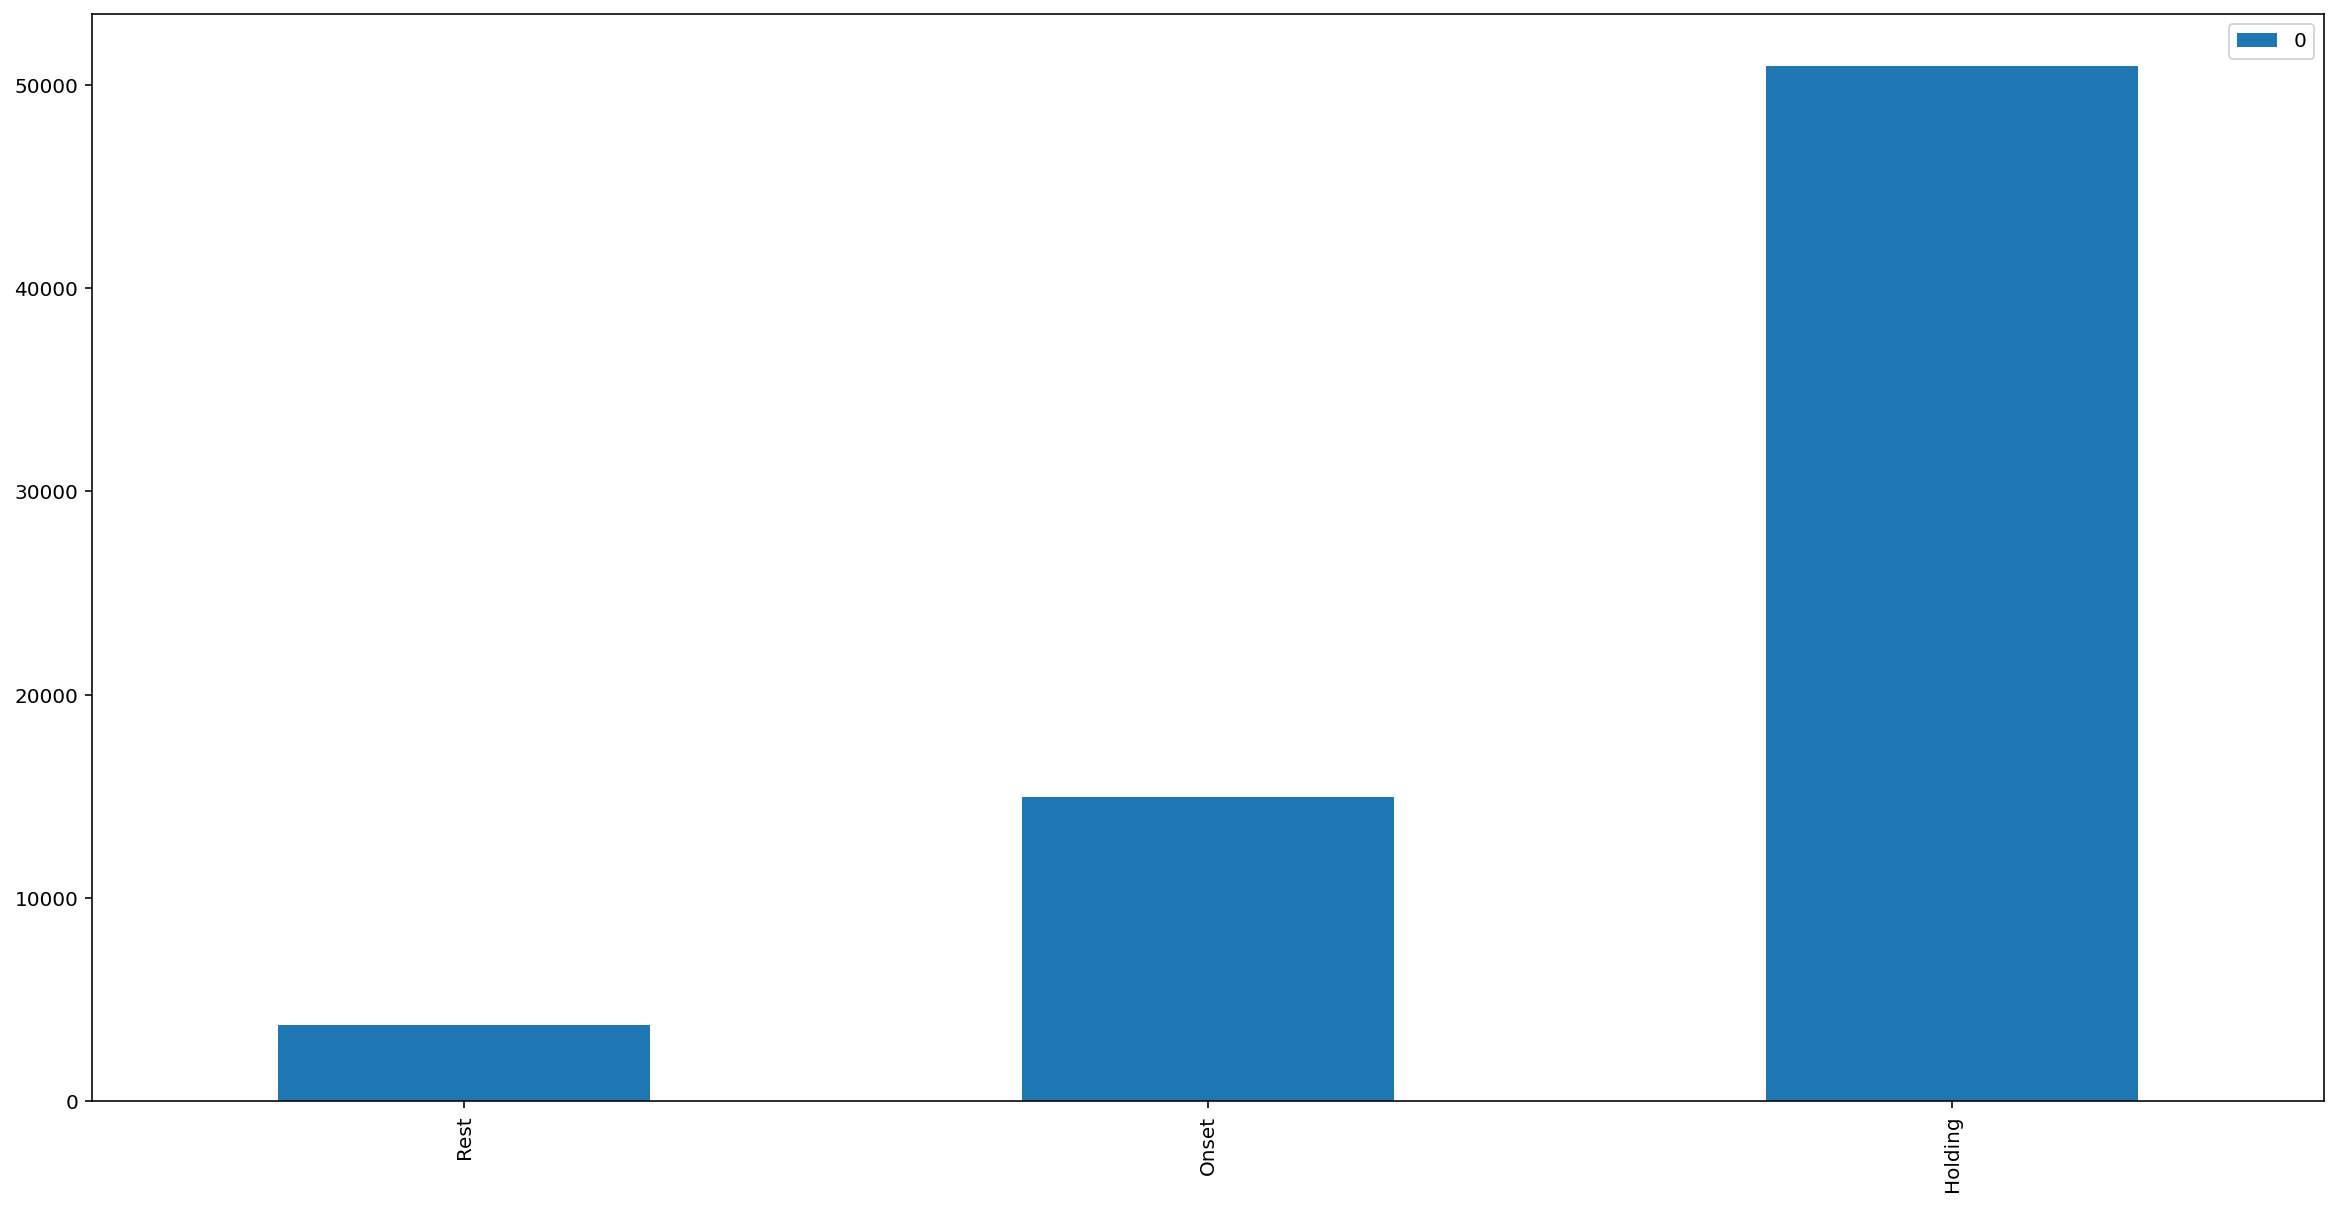

In [97]:
pd.DataFrame(np.sum(concat_note_status, axis=0), index=['Rest', 'Onset', 'Holding']).plot.bar(figsize=(20,10))

In [25]:
cut_np_scores = concat_np_scores[:, :, 47:84]

In [26]:
result = np.concatenate([cut_np_scores, concat_note_status], axis=2)

In [27]:
result.shape

(1247, 128, 40)

In [28]:
import pickle

In [29]:
with open('../data/melody_data.pkl', 'wb') as f:
  pickle.dump(result, f)

In [30]:
with open('../data/chord_data.pkl', 'wb') as f:
  pickle.dump(concat_chord_status, f)